### Postprocessing the simulation results
 
In this notebook, we demonstrate how to generate postprocess the simulation results obtained in the previous steps. In particular, we show how to compute surface integrals over interior interfaces and perform point evaluations.

First, we import the relevant packages and set a few relevant parameters:

In [1]:
from fenics import *
from multiphenics import *
from biotStokesWeakForm import create_function_spaces  
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import dufte
for k,v in dufte.style.items():
    if "color" in k:
        dufte.style[k] = "black"
plt.style.use("science")
plt.style.use(dufte.style)
plt.rcParams.update({'font.size': 16})


porous_id = 1
fluid_id = 2

# facet ids
skull_id = 1
spinal_canal_id = 2
interface_id = 3
spinal_cord_id = 4
aqueduct_V4_id = 5

u_degree, p_degree = (2,1)
T = 8
num_steps = int(T*40)
dt = T / num_steps
times = np.linspace(0, T, num_steps + 1)

Next, we read the mesh, and subdomain and facets marker, and mesh restrictions to recreate the function space:

In [2]:
mesh = Mesh()
with XDMFFile("mesh/mesh.xdmf") as f:
    f.read(mesh)
    sm = MeshFunction("size_t", mesh, 3, 0)
    f.read(sm, "subdomains")
    
with XDMFFile("mesh/facets.xdmf") as f:
    bm = MeshFunction("size_t", mesh, 2, 0)
    f.read(bm)
    
fluid_restriction = MeshRestriction(mesh, "mesh/fluid.rtc.xdmf")
porous_restriction = MeshRestriction(mesh, "mesh/porous.rtc.xdmf")

H = create_function_spaces(mesh, u_degree, p_degree,
                           fluid_restriction, porous_restriction)
dS = Measure("dS", domain=mesh, subdomain_data=bm)
ds = Measure("ds", domain=mesh, subdomain_data=bm)
dxP = Measure("dx", domain=mesh, subdomain_data=sm)(porous_id)

Now, we can read in the velocity field from file:

In [3]:
u_time_series = []
with XDMFFile("results_postp.xdmf") as f:
    for i in range(num_steps + 1):
        u = BlockFunction(H)[0]
        f.read_checkpoint(u, "u", i)
        u_time_series.append(u)

And compute the flow through the surface between the aqueduct and the fourth ventricle:
$$ q_{AQ} (t) =  \int_{AQ} u (t) \cdot n dS $$
and the outflow through the spinal canal:

In [4]:
aqflow = []
spflow = []
m3toml = 1e6
n = FacetNormal(mesh)
for u in u_time_series:
    aqflow.append(assemble(inner(u,n("+"))*dS(aqueduct_V4_id)))
    spflow.append(assemble(inner(u,n)*ds(spinal_canal_id)))

aqflow = np.array(aqflow) * m3toml
spflow = np.array(spflow) * m3toml
parenchyma_vol = assemble(1*dxP)*m3toml
inflow = np.sin(2*np.pi*times)*parenchyma_vol*0.01

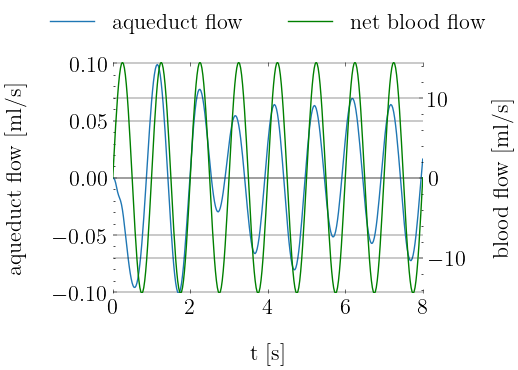

In [5]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax2 = ax1.twinx()

l1 = ax1.plot(times, aqflow)
l2 = ax2.plot(times, inflow, "g")

ax1.set_ylabel("aqueduct flow [ml/s]")
ax2.set_ylabel("blood flow [ml/s]")
ax1.set_ylim((-max(abs(aqflow)), max(abs(aqflow))))
ax2.set_ylim((-max(abs(inflow)), max(abs(inflow))))

labs = ["aqueduct flow", "net blood flow"]
ax1.legend(l1 + l2, labs, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
ax1.set_xlabel("t [s]")
plt.savefig("aqueduct_flow.pdf")

Additionally, we are interested in the evolution of the intracranial pressure and hence read in the fluid pressure field:

In [6]:
ICP_time_series = []
with XDMFFile("results_postp.xdmf") as f:
    for i in range(num_steps + 1):
        p = BlockFunction(H)[1]
        f.read_checkpoint(p, "pF", i)
        ICP_time_series.append(p)

To perform point evaluations of the pressure, we define our points of interest (the midpoint of the ventricular sphere and at the end of the aqueduct in the SAS) and and iterate over the time series of pressure fields: 

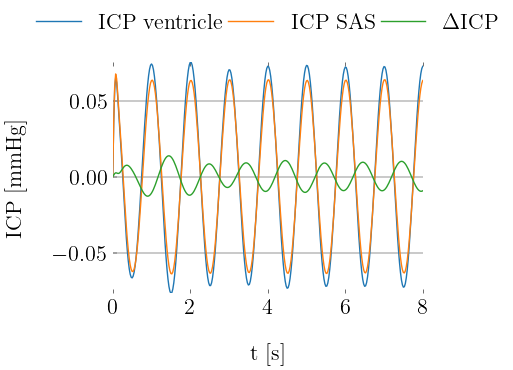

In [7]:
ventricle_mid = Point(0,0,0)
aq_out = Point(0, 0.055, -0.055)
pa2mmhg = 1.0/133.32
icp_ventricle = np.array([p(ventricle_mid)*pa2mmhg for p in ICP_time_series])
icp_aq_out = np.array([p(aq_out)*pa2mmhg for p in ICP_time_series])

plt.figure(figsize=(4,3))
plt.plot(times, icp_ventricle, label="ICP ventricle")
plt.plot(times, icp_aq_out, label="ICP SAS")
plt.plot(times, icp_aq_out - icp_ventricle, label=r'$\Delta$ICP')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, columnspacing=0.2)
plt.xlabel("t [s]")
plt.ylabel("ICP [mmHg]")
plt.savefig("ICP.pdf")